In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import re
import seaborn as sns
from datetime import datetime
import pytz
from pytz import timezone
#from google.colab import drive
import datetime
from datetime import timedelta
import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score



In [14]:
df_tn_reg = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\TN_EV_Registrations.csv')
df=pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\Session-Details-Summary-20240605_with_distances.csv')
df_venue= pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\lat_long_charging_venue.csv')
df_GIS= pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\rechargingstationproject\GIS_distance.xlsx', sheet_name='Total')
df_tn_population = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\tennessee_counties_population.csv')
df_tn_AADT = pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\TN_AADT_TDOT.xlsx')
df_tn_MHHI_county = pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\Median_H_H_Income.xlsx')
df_tn_TEMP_county = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\2023_TN_County_Average_Temperature.csv')
df_tn_Cooling_Degree_Days_county = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\2023_TN_County_Cooling_Degree_Days.csv')

In [15]:
def mean_excluding_zeros(series):
    non_zero_values = series[series != 0]
    if len(non_zero_values) > 0:
        return np.mean(non_zero_values)
    else:
        return np.nan
#-----------------------------
def convert_duration_to_seconds(duration):
    if isinstance(duration, str):
        parts = duration.split(':')
        if len(parts) >= 3:
            try:
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = int(parts[2].split()[0])
                total_seconds = hours * 3600 + minutes * 60 + seconds
                return total_seconds
            except (IndexError, ValueError):
                print("Invalid duration format")
                return 0
        else:
            print("Invalid duration format")
            return 0
    elif isinstance(duration, datetime.time):
        return duration.hour * 3600 + duration.minute * 60 + duration.second
    else:
        return 0
#--------------------------------------------------------------------------------

def convert_to_est_old(row, date_col, tz_col):
    tz_map = {'EST': 'America/New_York', 'CST': 'America/Chicago', 'CDT': 'America/Chicago', 'EDT': 'America/New_York', 'PDT': 'America/Los_Angeles', 'PST': 'America/Los_Angeles'}
    return row[date_col].tz_localize(tz=tz_map[row[tz_col]], ambiguous='NaT').tz_convert(tz='EST')


time_zones = {
    'EST': 'America/New_York',
    'CST': 'America/Chicago',
    'CDT': 'America/Chicago',
    'EDT': 'America/New_York',
    'PDT': 'America/Los_Angeles',
    'PST': 'America/Los_Angeles'
}

# Convert time zones 
def convert_to_est(row):
    est_tz = timezone('America/New_York')
    start_tz = timezone(time_zones[row['Start Time Zone']])
    end_tz = timezone(time_zones[row['End Time Zone']])

    row['Start Date'] = row['Start Date'].astimezone(start_tz).astimezone(est_tz)
    row['End Date'] = row['End Date'].astimezone(end_tz).astimezone(est_tz)

    return row

#--------------------------------------------------------------------------------

missing_count = df['Port Type'].value_counts().get('Missing', 0)
df = df.dropna(subset=['Port Type'])

# Apply function to Start and End Date
df['Start_Time_EST'] = pd.to_datetime(df['Start Date'])
df['End_Time_EST'] = pd.to_datetime(df['End Date'])


#sorting
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])


#    Total duration  Charging time   parking time   End charging Time

df['Total Duration'] = (df['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600
df['Charging Time'] = (df['Charging Time (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600
#df['Charging Time (dayTime)'] = df['Charging Time (hh:mm:ss)'].apply(lambda x: pd.Timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))
df.loc[df['Charging Time'] > df['Total Duration'], 'Charging Time'] = df['Total Duration']
df['parking_time'] = df['Total Duration'] - df['Charging Time']
df['End_Charging_Time_EST'] = [date + timedelta(hours=chargingtime) for date, chargingtime in df[['Start_Time_EST','Charging Time']].itertuples(index=False)]
#df['End_Charging_Time_EST_2']= df['Start_Time_EST'] +df['Charging Time (dayTime)']

# Data cleaning 
# sessions with delivered energy > 140 kWh, since these are incompatible with the usable battery capacities of the Rivian 
# R1T and extended-range Ford F-150 Lighting, the two mass-market EVs with the largest batteries available through March 2022;
# (2) sessions with a charge duration of 0 h or where no energy was delivered; 

df = df[(df['Energy (kWh)'] != 0) & (df['Energy (kWh)'] <= 140) & (df['Charging Time']!=0)]

In [16]:

# wich day of week
df['Day_of_Week'] = df['Start_Time_EST'].dt.dayofweek

# Create new columns 'Is_Weekday' and 'Is_Weekend'
df['Is_Weekday'] = df['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

# Peak hour 
# Add a new column 'peak_hour'
df['Start_Time_EST_Day'] = pd.to_datetime(df['Start_Time_EST']).dt.hour
df['peak_hour'] = ((df['Start_Time_EST_Day'] >= 6) & (df['Start_Time_EST_Day'] <= 20)).astype(int)


# Extract the month from 'Start Date' 
df['month'] = pd.to_datetime(df['Start_Time_EST']).dt.month

def month_to_season(month):
    if month in [12, 1, 2]:
        return 4  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

df['season'] = df['month'].apply(month_to_season)



# Create new columns 'DC' and 'L2'
df['DC'] = (df['Port Type'] == 'DC Fast').astype(int)
df['L2'] = (df['Port Type'] == 'Level 2').astype(int)
df['Port Type'] = df['Port Type'].fillna('')

#Cost --> cost_free: Binary variable indicating if the station offers free charging
#     ---> cost_paid: Binary variable indicating if the station offers paid charging
df['Fee'] = df['Fee'].fillna(0)
df['cost_free'] = (df['Fee'] == 0).astype(int)
df['cost_paid'] = (df['Fee'] > 0).astype(int)


# If location of CS and driver are the same 

df['same_location'] = (df['Zip/Postal Code'] == df['Driver Zip/Postal Code']).astype(int)



# Add VENUE features


df['ven_leisure'] = (df['Charging Venue'] == 'Leisure').astype(int)
df['ven_med_ed'] = ((df['Charging Venue'] == 'Edu') | (df['Charging Venue'] == 'Medical' )).astype(int)
df['ven_HWY'] = (df['Charging Venue'] == 'HWY').astype(int)
df['ven_office'] = (df['Charging Venue'] == 'Office').astype(int)
df['ven_parking'] = (df['Charging Venue'] == 'Parking').astype(int)
df['ven_retail'] = (df['Charging Venue'] == 'Shopping').astype(int)
df['ven_Hotel'] = (df['Charging Venue'] == 'Hotel').astype(int)



#sorting data
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])

# idle time
#df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'], utc=True).dt.tz_convert('EST')
#df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'], utc=True).dt.tz_convert('EST')

df['previous_end_time'] = df.groupby(['EVSE ID','Port Number'])['End_Time_EST'].shift(1)
df['idle'] = df['Start_Time_EST'] - df['previous_end_time']
df['idle_hour']= (df['idle'].dt.total_seconds())/3600
df['idle_day']= (df['idle'].dt.total_seconds())/86400

# Calculate SOC difference
df['Start SOC'] = df['Start SOC'].str.replace('%', '').fillna(0).astype('int64')
df['End SOC'] = df['End SOC'].str.replace('%', '').fillna(0).astype('int64')
df['SOC_diff'] = df['End SOC'] - df['Start SOC']
mean_soc_diff_without_zeros = df[df['SOC_diff'] != 0]['SOC_diff'].mean()




#sorting df
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df.reset_index(drop=True, inplace=True)

####   Normalization based on service  #####
evse_service_time = df.groupby('EVSE ID').agg({'Start_Time_EST': 'min', 'End_Time_EST': 'max'})
evse_service_time['Service_Days'] = (evse_service_time['End_Time_EST'] - evse_service_time['Start_Time_EST']).dt.days
evse_service_time.reset_index(inplace=True)
df = pd.merge(df, evse_service_time[['EVSE ID', 'Service_Days']], on='EVSE ID', how='left')

df['Event Count'] = df.groupby('EVSE ID')['EVSE ID'].transform('count')
df['Normalized Event Count'] = df['Event Count'] / df['Service_Days']


###### Estimate of the rated power level for that EVSE port.
df['Power_Delivered'] = df['Energy (kWh)'] / df['Charging Time']
port_kw_estimate = df.groupby(['EVSE ID', 'Port Number'])['Power_Delivered'].mean().reset_index()
df = pd.merge(df, port_kw_estimate, on=['EVSE ID', 'Port Number'], how='left')
df = df.drop(columns=['Power_Delivered_x'])
df = df.drop(columns=['Power_Delivered_y'])
port_kw_estimate = port_kw_estimate.rename(columns={'Power_Delivered': 'port_kw'})
df = pd.merge(df, port_kw_estimate, on=['EVSE ID', 'Port Number'], how='left')




#---------------------------------------------------------------------------------------------------------------------
###  Utilizatiion Rate   ####
unique_ports_per_evse = df.groupby('EVSE ID')['Port Number'].nunique()
total_charging_time_evse=df.groupby('EVSE ID')['Charging Time'].sum()

utilization_data = pd.DataFrame({
    'EVSE ID': unique_ports_per_evse.index,
    'Number of Ports': unique_ports_per_evse.values,
    'Total Charging Time (hours)': total_charging_time_evse,
    'Service Days': df.groupby('EVSE ID')['Service_Days'].max()

})

#  Calculate the utilization rate of existing charging stations
#  total charging time / the total available time
#  Calculate the total available time in hours ---> total available time (24 hours * number of days * number of ports)
#utilization_data['Total Available Time (hours)'] = utilization_data['Number of Ports'] * utilization_data['Service Days'] * 24

# Calculate the utilization rate
#utilization_data['Utilization Rate'] = utilization_data['Total Charging Time (hours)'] / utilization_data['Total Available Time (hours)']

#---------------------------------------------------------------------------------------------------------------------
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
####   DC and L2 df  ####
df_L2 = df[df['Port Type'].str.fullmatch('Level 2')]
df_DC = df[df['Port Type'].str.fullmatch('DC Fast')]





In [17]:
df.columns

Index(['MAC Address', 'Org Name', 'Start Date', 'Start Time Zone', 'End Date',
       'End Time Zone', 'Transaction Date (Pacific Time)',
       'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)', 'Energy (kWh)',
       'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Port Type',
       'Port Number', 'Plug Type', 'EVSE ID', 'Address 2', 'Country',
       'Currency', 'Fee', 'Ended By', 'Plug In Event ID', 'Transaction ID',
       'Driver Zip/Postal Code', 'User ID', 'Start SOC', 'End SOC', 'County',
       'System S/N', 'Model Number', 'OnRamp ID Tag',
       'Payment Terminal Session ID', 'Vehicle MAC ID', 'Charging Venue',
       'Station Name', 'Address 1', 'City', 'Zip/Postal Code',
       'State/Province', 'Latitude (y)', 'Longitude (x)', 'Distance (miles)',
       'Start_Time_EST', 'End_Time_EST', 'Total Duration', 'Charging Time',
       'parking_time', 'End_Charging_Time_EST', 'Day_of_Week', 'Is_Weekday',
       'Is_Weekend', 'Start_Time_EST_Day', 'peak_hour', 'month', '

In [18]:
user_station_counts = df.groupby('User ID')['EVSE ID'].nunique().reset_index()
user_station_counts.columns = ['User ID', 'Unique_Stations_Used']

total_users = len(user_station_counts)
users_with_multiple_stations = (user_station_counts['Unique_Stations_Used'] > 1).sum()
users_with_single_station = (user_station_counts['Unique_Stations_Used'] == 1).sum()

percent_multiple = (users_with_multiple_stations / total_users) * 100
percent_single = (users_with_single_station / total_users) * 100

station_count_stats = user_station_counts['Unique_Stations_Used'].describe() 

print(f"Total users: {total_users}")
print(f"Users using multiple stations: {users_with_multiple_stations} ({percent_multiple:.2f}%)")
print(f"Users using only one station: {users_with_single_station} ({percent_single:.2f}%)")
print("\nDistribution of unique stations used per user:")
print(station_count_stats)


# Optional: Find users who use the most diverse set of charging stations
top_diverse_users = user_station_counts.nlargest(15, 'Unique_Stations_Used')
print("\nTop 10 users with the most diverse charging station usage:")
print(top_diverse_users)

Total users: 9787
Users using multiple stations: 2251 (23.00%)
Users using only one station: 7536 (77.00%)

Distribution of unique stations used per user:
count    9787.000000
mean        1.366404
std         0.942452
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        28.000000
Name: Unique_Stations_Used, dtype: float64

Top 10 users with the most diverse charging station usage:
       User ID  Unique_Stations_Used
2894   2770771                    28
3316  29015001                    28
3200    285839                    15
6719  40181621                    13
1631  24221361                    11
9587    590521                    11
759   21944411                     9
929   22396771                     9
1353  23545731                     9
3265  28793261                     9
4886  34392251                     9
5724  36881541                     9
7916  44487081                     9
8       105723                     8
561   21161871     

# Daily usage 

In [21]:
df = df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Date'] = df['Start_Time_EST'].dt.date

# 2023 and TN State 
df_tennessee_2023 = df.copy()   
#[(df['State/Province'] == 'Tennessee')]
#df_tennessee_2023 = df[df['Start_Time_EST'].dt.year == 2023]
#df_tennessee_2023 = df[(df['Start_Time_EST'].dt.year == 2023) | (df['Start_Time_EST'].dt.year == 2024)]
df_tennessee_2023['Date'] = df_tennessee_2023['Start_Time_EST'].dt.date


unique_ports_per_evse = df_tennessee_2023.groupby('EVSE ID')['Port Number'].nunique().reset_index()
daily_usage_evse = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Energy (kWh)'].sum().reset_index()

daily_charging_time_evse=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Charging Time'].sum().reset_index()
daily_parking_time_evse=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['parking_time'].sum().reset_index()

daily_average_start_soc_evse=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Start SOC'].mean().reset_index()
daily_average_end_soc_evse=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['End SOC'].mean().reset_index()

daily_fee_evse=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Fee'].sum().reset_index()
zip_code_estimate = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Distance (miles)'].sum().reset_index()
season_df = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['season'].mean().reset_index()
peak_hour_df = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['peak_hour'].sum().reset_index()
GHG_saving = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['GHG Savings (kg)'].sum().reset_index()
gasoline_saving = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Gasoline Savings (gallons)'].sum().reset_index()
daily_unique_users = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['User ID'].nunique().reset_index(name='Unique_Users')
idle_time = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['idle_hour'].sum().reset_index()


# Calculate the number of charging events per day per EVSE ID 
daily_events = df_tennessee_2023.groupby(['EVSE ID', 'Date']).size().reset_index()
daily_events.columns = ['EVSE ID', 'Date', 'Number of Events']

#   Create utilization_station_data DataFrame 
utilization_station_data = pd.merge(unique_ports_per_evse, daily_usage_evse, on='EVSE ID', how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_events, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_charging_time_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_parking_time_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_average_start_soc_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_average_end_soc_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_fee_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, zip_code_estimate, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, season_df, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, peak_hour_df, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, GHG_saving, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, gasoline_saving, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_unique_users, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, idle_time, on=['EVSE ID', 'Date'], how='left')


# Create new columns 'Is_Weekday' and 'Is_Weekend'
utilization_station_data['Day_of_Week'] = pd.to_datetime(utilization_station_data['Date']).dt.dayofweek
utilization_station_data['Is_Weekday'] = utilization_station_data['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
utilization_station_data['Is_Weekend'] = utilization_station_data['Day_of_Week'].isin([5, 6]).astype(int)


merged_df = df[['EVSE ID', 'Charging Venue', 'City', 'Station Name', 'Address 1', 'State/Province', 'County',
                     'Zip/Postal Code', 'Latitude (y)', 'Longitude (x)', 'Port Type']].drop_duplicates()
utilization_station_data = pd.merge(utilization_station_data, merged_df, on='EVSE ID', how='left')

# Normalized Event count 
merged_df_normalized =  df_tennessee_2023[['EVSE ID', 'Normalized Event Count']].drop_duplicates()
utilization_station_data = pd.merge(utilization_station_data, merged_df_normalized, on='EVSE ID', how='left')



merged_df_utilization_rate = utilization_data[['EVSE ID', 'Number of Ports']].drop_duplicates().reset_index(drop=True)
utilization_station_data = pd.merge(utilization_station_data, merged_df_utilization_rate, on='EVSE ID', how='left')

# Estimate of the rated power level for that EVSE port.
df['Power_Delivered'] = df['Energy (kWh)'] / df['Charging Time']

utilization_station_data['Unit_price'] = utilization_station_data['Fee']*100/ utilization_station_data['Energy (kWh)']

#Venue
utilization_station_data['ven_hotel'] = (utilization_station_data['Charging Venue'] == 'Hotel').astype(int)
utilization_station_data['ven_leisure'] = (utilization_station_data['Charging Venue'] == 'Leisure').astype(int)
utilization_station_data['ven_med_ed'] = ((utilization_station_data['Charging Venue'] == 'Medical') | (utilization_station_data['Charging Venue'] == 'Edu' )).astype(int)
utilization_station_data['ven_HWY'] = (utilization_station_data['Charging Venue'] == 'HWY').astype(int)
utilization_station_data['ven_office'] = (utilization_station_data['Charging Venue'] == 'Office').astype(int)
utilization_station_data['ven_parking'] = (utilization_station_data['Charging Venue'] == 'Parking').astype(int)
utilization_station_data['ven_retail'] = (utilization_station_data['Charging Venue'] == 'Shopping').astype(int)

# CDC or L2

utilization_station_data['DC'] = (utilization_station_data['Port Type'] == 'DC Fast').astype(int)
utilization_station_data['L2'] = (utilization_station_data['Port Type'] == 'Level 2').astype(int)

# Cost free or paid
utilization_station_data['cost_free'] = (utilization_station_data['Fee'] == 0).astype(int)
utilization_station_data['cost_paid'] = (utilization_station_data['Fee'] > 0).astype(int)

# USER-CS Matrix

In [22]:


df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['year_month'] = df['Start_Time_EST'].dt.to_period('M')


def create_monthly_matrix(month_data):
    grouped = month_data.groupby(['User ID', 'EVSE ID']).size().reset_index(name='count')
    matrix = grouped.pivot(index='User ID', columns='EVSE ID', values='count').fillna(0)
    return matrix

monthly_matrices = df.groupby('year_month').apply(create_monthly_matrix)
monthly_matrices=monthly_matrices.fillna(0)


C:\Users\mehdi\AppData\Local\Temp\ipykernel_9260\245459227.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_matrices = df.groupby('year_month').apply(create_monthly_matrix)


In [24]:
monthly_matrices

EVSE ID              682921    1785631   1844191   1921351   1921531   \
year_month User ID                                                      
2018-11    1696621        2.0       0.0       0.0       0.0       0.0   
           1697831        1.0       0.0       0.0       0.0       0.0   
           2770771        2.0       0.0       0.0       0.0       0.0   
           842706         9.0       0.0       0.0       0.0       0.0   
2018-12    1696621        3.0       0.0       0.0       0.0       0.0   
...                       ...       ...       ...       ...       ...   
2024-06    50920481       0.0       0.0       0.0       0.0       0.0   
           50922531       0.0       0.0       0.0       0.0       0.0   
           50935041       0.0       0.0       0.0       0.0       0.0   
           590521         0.0       0.0       0.0       0.0       0.0   
           809877         0.0       0.0       0.0       0.0       0.0   

EVSE ID              1932851   1933211   1964521   1988061   1988141   ...  \
year_month User ID                                                     ...   
2018-11    1696621        0.0       0.0       0.0       0.0       0.0  ...   
           1697831        0.0       0.0       0.0       0.0       0.0  ...   
           2770771        0.0       0.0       0.0       0.0       0.0  ...   
           842706         0.0       0.0       0.0       0.0       0.0  ...   
2018-12    1696621        0.0       0.0       0.0       0.0       0.0  ...   
...                       ...       ...       ...       ...       ...  ...   
2024-06    50920481       0.0       0.0       0.0       0.0       0.0  ...   
           50922531       0.0       0.0       0.0       0.0       0.0  ...   
           50935041       0.0       0.0       0.0       0.0       0.0  ...   
           590521         0.0       0.0       0.0       0.0       0.0  ...   
           809877         0.0       0.0       0.0       0.0       0.0  ...   

EVSE ID              15623231  15640031  15640171  15684301  15684341  \
year_month User ID                                                      
2018-11    1696621        0.0       0.0       0.0       0.0       0.0   
           1697831        0.0       0.0       0.0       0.0       0.0   
           2770771        0.0       0.0       0.0       0.0       0.0   
           842706         0.0       0.0       0.0       0.0       0.0   
2018-12    1696621        0.0       0.0       0.0       0.0       0.0   
...                       ...       ...       ...       ...       ...   
2024-06    50920481       0.0       0.0       0.0       0.0       0.0   
           50922531       0.0       0.0       0.0       0.0       0.0   
           50935041       0.0       0.0       0.0       0.0       0.0   
           590521         0.0       0.0       0.0       0.0       0.0   
           809877         0.0       0.0       0.0       0.0       0.0   

EVSE ID              15694081  15694171  15729991  15742641  15815141  
year_month User ID                                                     
2018-11    1696621        0.0       0.0       0.0       0.0       0.0  
           1697831        0.0       0.0       0.0       0.0       0.0  
           2770771        0.0       0.0       0.0       0.0       0.0  
           842706         0.0       0.0       0.0       0.0       0.0  
2018-12    1696621        0.0       0.0       0.0       0.0       0.0  
...                       ...       ...       ...       ...       ...  
2024-06    50920481       0.0       0.0       0.0       0.0       0.0  
           50922531       0.0       0.0       0.0       0.0       0.0  
           50935041       0.0       0.0       0.0       0.0       0.0  
           590521         0.0       0.0       0.0       0.0       0.0  
           809877         0.0       0.0       0.0       0.0       0.0  

[17791 rows x 120 columns]

- U_k:    Each row represents a user, and each column represents a latent factor. This matrix captures user characteristics in the latent space.

- V_k^T:  Each column represents an EVSE station, and each row represents a latent factor. This matrix captures station characteristics in the latent space.

- Σ_k:    The diagonal values represent the importance of each latent factor.

Reconstruction and Predictions:
We can approximate the original matrix or predict missing values by multiplying these matrices:

 A' ≈ U_k * Σ_k * V_k^T


This reconstructed matrix A' can be used to fill in missing values or make predictions about user-station interactions.

## Melt the DataFrame to long format

In [25]:
monthly_matrices_reset = monthly_matrices.reset_index()

melted_df = pd.melt(monthly_matrices_reset, 
                    id_vars=['year_month', 'User ID'], 
                    var_name='EVSE ID', 
                    value_name='count')

melted_df['year_month'] = pd.to_datetime(melted_df['year_month'].astype(str))
melted_df = melted_df.sort_values(['year_month', 'User ID', 'EVSE ID'])


In [26]:
melted_df

year_month  User ID   EVSE ID  count
0       2018-11-01  1696621    682921    2.0
17791   2018-11-01  1696621   1785631    0.0
35582   2018-11-01  1696621   1844191    0.0
53373   2018-11-01  1696621   1921351    0.0
71164   2018-11-01  1696621   1921531    0.0
...            ...      ...       ...    ...
2063755 2024-06-01   809877  15694081    0.0
2081546 2024-06-01   809877  15694171    0.0
2099337 2024-06-01   809877  15729991    0.0
2117128 2024-06-01   809877  15742641    0.0
2134919 2024-06-01   809877  15815141    0.0

[2134920 rows x 4 columns]


### Matrix Factorization  SVD

In [27]:
def matrix_factorization(year_month_data, k=10):
    # Create user and station encodings
    users = year_month_data['User ID'].astype('category').cat.codes
    stations = year_month_data['EVSE ID'].astype('category').cat.codes
    
    # Create sparse matrix
    matrix = csr_matrix((year_month_data['count'], (users, stations)))
    
    min_dim = min(matrix.shape)
    if min_dim <= 1:
        return None, None, None, None
    
    k = min(k, min_dim - 1)
    
    try:
        U, s, Vt = svds(matrix, k=k)
        
        # Reconstruct the matrix
        reconstructed_matrix = U @ np.diag(s) @ Vt
        
        # Convert back to DataFrames with original labels
        user_index = year_month_data['User ID'].astype('category').cat.categories
        station_index = year_month_data['EVSE ID'].astype('category').cat.categories
        
        U_df = pd.DataFrame(U, index=user_index)
        Vt_df = pd.DataFrame(Vt.T, index=station_index)
        reconstructed_df = pd.DataFrame(reconstructed_matrix, index=user_index, columns=station_index)
        
        return U_df, pd.Series(s), Vt_df, reconstructed_df
    except Exception as e:
        print(f"Error in matrix factorization: {str(e)}")
        return None, None, None, None
 
def process_monthly_data(melted_df): 
    results = {}
    for year_month, group in melted_df.groupby('year_month'):
        user_factors, singular_values, station_factors, reconstructed = matrix_factorization(group)
        if user_factors is not None:
            results[year_month] = {
                'user_factors': user_factors,
                'singular_values': singular_values,
                'station_factors': station_factors,
                'reconstructed': reconstructed
            }
        else:
            print(f"Skipping month {year_month} due to insufficient data")
    
    print(f"Successfully processed {len(results)} out of {melted_df['year_month'].nunique()} months")
    return results

# Main execution
# Assuming melted_df is existing DataFrame with columns: 'year_month', 'User ID', 'EVSE ID', 'count' 
results = process_monthly_data(melted_df)



Successfully processed 68 out of 68 months


C:\Users\mehdi\AppData\Local\Temp\ipykernel_2036\2137581244.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


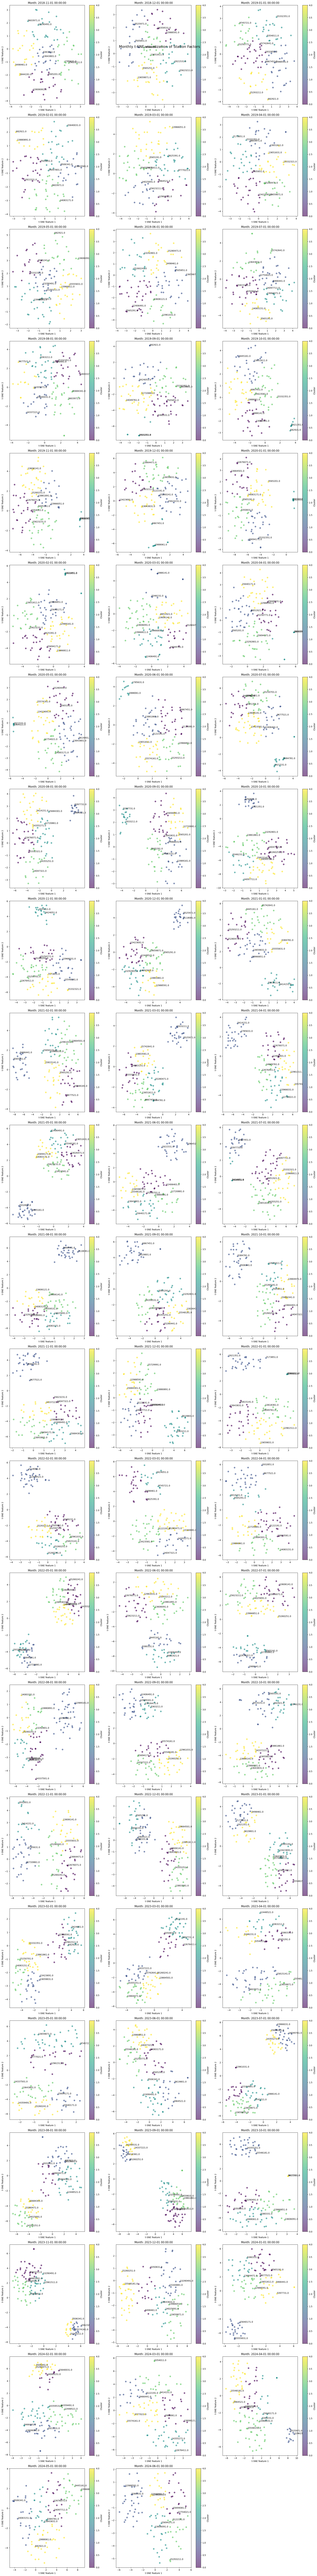

In [176]:
def apply_tsne_and_cluster(results, n_clusters=5):
    monthly_tsne_results = {}
    
    for year_month, data in results.items():
        station_factors = data['station_factors']
        
        
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(station_factors.values)
        
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(tsne_results)
        
        
        tsne_df = pd.DataFrame({
            'x': tsne_results[:, 0],
            'y': tsne_results[:, 1],
            'EVSE ID': station_factors.index,
            'cluster': cluster_labels
        })
        
        monthly_tsne_results[year_month] = tsne_df
    
    return monthly_tsne_results

def plot_colorful_tsne_results(monthly_tsne_results):
    num_months = len(monthly_tsne_results)
    cols = 3
    rows = (num_months + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 7*rows))
    fig.suptitle('Monthly t-SNE visualization of Station Factors', fontsize=16)
    
    # Create a colormap
    cmap = plt.cm.get_cmap('viridis')
    
    for i, (year_month, tsne_df) in enumerate(monthly_tsne_results.items()):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        
        # Create scatter plot with colors based on clusters
        scatter = ax.scatter(tsne_df['x'], tsne_df['y'], c=tsne_df['cluster'], 
                             cmap=cmap, alpha=0.6)
        
        ax.set_title(f'Month: {year_month}')
        ax.set_xlabel('t-SNE feature 1')
        ax.set_ylabel('t-SNE feature 2')
        
        # Add EVSE ID labels to a few random points from each cluster
        for cluster in tsne_df['cluster'].unique():
            cluster_points = tsne_df[tsne_df['cluster'] == cluster].sample(min(2, sum(tsne_df['cluster'] == cluster)))
            for _, point in cluster_points.iterrows():
                ax.annotate(point['EVSE ID'], (point['x'], point['y']))
        
        # Add a colorbar to show cluster assignments
        plt.colorbar(scatter, ax=ax, label='Cluster')
    
    # Remove any unused subplots
    if rows > 1:
        for j in range(i+1, rows*cols):
            fig.delaxes(axes[j // cols, j % cols])
    else:
        for j in range(i+1, cols):
            fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def find_similar_stations(tsne_df, evse_id, n=5):
    station_coords = tsne_df[tsne_df['EVSE ID'] == evse_id][['x', 'y']].values[0]
    tsne_df['distance'] = tsne_df.apply(lambda row: np.linalg.norm(row[['x', 'y']].values - station_coords), axis=1)
    return tsne_df.sort_values('distance').head(n+1)[['EVSE ID', 'cluster', 'distance']]

# Main execution
monthly_tsne_results = apply_tsne_and_cluster(results, n_clusters=5)
plot_colorful_tsne_results(monthly_tsne_results)

# Example of finding similar stations for a specific month
# month = '2023-01'  # Replace with an actual month in your data
# similar_stations = find_similar_stations(monthly_tsne_results[month], 'EVSE_ID_1', n=5)
# print(f"Stations similar to EVSE_ID_1 in {month}:\n{similar_stations}")

